<a href="https://colab.research.google.com/github/upadrastaharshavardhan/0569-hacker_rank/blob/main/Brain_Tumor_Detection_Using_Pytorch_auth_harsha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for **Brain** Tumor Detection Using Pytorch

In [1]:
!pip install split-folders

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Step 2: Specify the path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Brain Tumor Data Set.zip'
extract_dir = '/content/drive/MyDrive/Brain Tumor Data Set'

# Ensure the extract directory exists
os.makedirs(extract_dir, exist_ok=True)

# Step 3: Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [4]:
os.listdir("/content/drive/MyDrive/Brain Tumor Data Set/Brain Tumor Data Set")

['Brain Tumor', 'Healthy']

In [5]:
data_dir = "/content/drive/MyDrive/Brain Tumor Data Set/Brain Tumor Data Set"
data_dir = pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output='brain', seed=41, ratio=(0.8, 0.2))

Copying files: 4600 files [02:00, 38.06 files/s] 


In [6]:
data_dir = "/content/brain"
data_dir = pathlib.Path(data_dir)

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [8]:
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('train'), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('val'), transform=transform)
val_set.transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [9]:
print(train_set)

Dataset ImageFolder
    Number of datapoints: 3679
    Root location: /content/brain/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


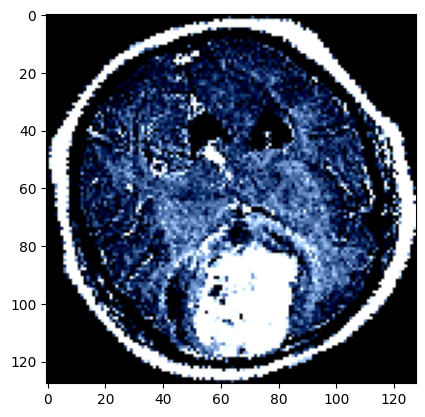

In [10]:
img, label = train_set[1000]
plt.imshow(img.permute(1,2,0))

In [11]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [12]:
next(iter(val_loader))[0].shape

torch.Size([64, 3, 128, 128])

In [13]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    #Conv 1
    self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #128-5+1=124

    #Max Pool 1
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) #124/2 = 64

    #Conv 2
    self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #60

    #Max Pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) #30

    #Conv 3
    self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) #26

    #Max Pool 3
    self.maxpool3 = nn.MaxPool2d(kernel_size=2) #13

    #Conv 4
    self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0) #9

    #Max Pool 4
    self.maxpool4 = nn.MaxPool2d(kernel_size=2) #4

    #Activation Function
    self.leakyRelu = nn.LeakyReLU()

    #Fully connected Layer 1
    self.fc1 = nn.Linear(128*4*4, 1024)

    #Fully connected Layer 2
    self.fc2 = nn.Linear(1024, 2)

  def forward(self, x):
    #Layer 1
    out = self.leakyRelu(self.cnv1(x))
    out = self.maxpool1(out)

    #Layer 2
    out = self.leakyRelu(self.cnv2(out))
    out = self.maxpool2(out)

    #Layer 3
    out = self.leakyRelu(self.cnv3(out))
    out = self.maxpool3(out)

    #Layer 4
    out = self.leakyRelu(self.cnv4(out))
    out = self.maxpool4(out)

    #flatten
    out = out.view(out.size(0), -1)

    # Linear Function
    out = self.leakyRelu(self.fc1(out))
    out = self.fc2(out)

    return out



In [14]:
# Training CNN
num_epochs = 10
model = CNNModel()
error = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [15]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
  train_loss = 0
  val_loss = 0
  for i, (images, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    outputs = model(images)
    loss = error(outputs, labels)
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("Loss in Iteration:", i, ":", loss.item())
  total = 0
  correct = 0
  for images, labels in val_loader:
    outputs = model(images)
    v_loss = error(outputs, labels)
    val_loss+=v_loss.item()
    predicted = torch.max(outputs.data, 1)[1]

    total+=len(labels)
    correct+=(predicted==labels).sum()


  scheduler.step(val_loss/len(val_loader))
  accuracy = 100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)
  print("Epoch:{}  Loss:{}  Acciracy:{}%".format(epoch, train_loss/len(train_loader), accuracy))

Loss in Iteration: 0 : 0.6932008862495422
Loss in Iteration: 1 : 0.704592764377594
Loss in Iteration: 2 : 0.844331681728363
Loss in Iteration: 3 : 0.7367039918899536
Loss in Iteration: 4 : 0.6803283095359802
Loss in Iteration: 5 : 0.6921238303184509
Loss in Iteration: 6 : 0.6917651891708374
Loss in Iteration: 7 : 0.6901392340660095
Loss in Iteration: 8 : 0.6875540018081665
Loss in Iteration: 9 : 0.6837633848190308
Loss in Iteration: 10 : 0.6819721460342407
Loss in Iteration: 11 : 0.6723434329032898
Loss in Iteration: 12 : 0.6890401840209961
Loss in Iteration: 13 : 0.656498372554779
Loss in Iteration: 14 : 0.7074055671691895
Loss in Iteration: 15 : 0.6817387342453003
Loss in Iteration: 16 : 0.6881148219108582
Loss in Iteration: 17 : 0.6939918398857117
Loss in Iteration: 18 : 0.6854737401008606
Loss in Iteration: 19 : 0.6818100214004517
Loss in Iteration: 20 : 0.687125027179718
Loss in Iteration: 21 : 0.6754075884819031
Loss in Iteration: 22 : 0.6623031497001648
Loss in Iteration: 23 : 0

In [16]:
train_loss_list

[0.6471420670377797,
 0.5217287740830717,
 0.3743532908887699,
 0.2980495100391322,
 0.2397379832791871,
 0.19210213782458468,
 0.18351487751150952,
 0.16347012569292865,
 0.13481632735708665,
 0.12657512310121594]

In [17]:
val_loss_list

[0.547265640894572,
 0.43954834938049314,
 0.3893657018740972,
 0.2291359121600787,
 0.19368799527486166,
 0.1668204113841057,
 0.15860375215609868,
 0.15771968762079874,
 0.11976847896973292,
 0.19123615100979804]

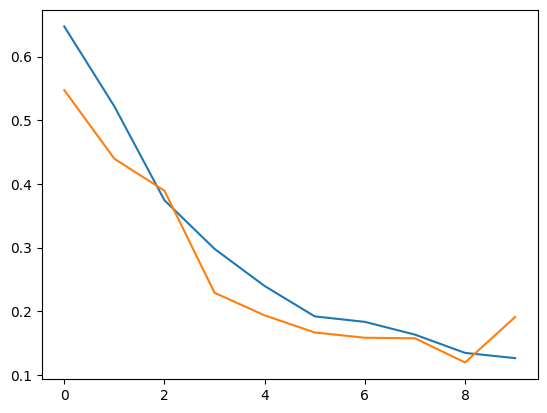

In [18]:
plt.plot(range(num_epochs), train_loss_list)
plt.plot(range(num_epochs), val_loss_list)

In [20]:
accuracy_list

[tensor(74.2671),
 tensor(80.0217),
 tensor(82.3018),
 tensor(91.0966),
 tensor(92.2910),
 tensor(93.5939),
 tensor(93.5939),
 tensor(93.8111),
 tensor(95.3312),
 tensor(93.9197)]

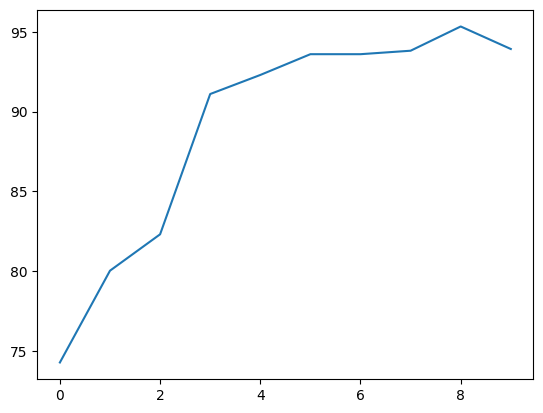

In [21]:
plt.plot(range(num_epochs), accuracy_list)

Text(0.5, 1.0, '0')

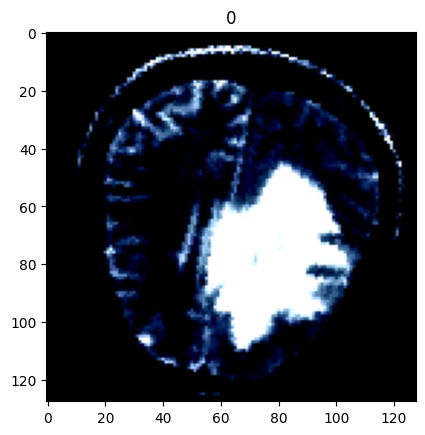

In [22]:
img, label = val_set[500]
plt.imshow(img.permute(1,2,0))
plt.title(label)

In [24]:
image = img.unsqueeze(0)

with torch.no_grad():
  output = model(image)

_, pred = torch.max(output, 1)
print("Predicted Output:", pred.item())

Predicted Output: 0


In [26]:
import json
import torch

# ... (Your existing code) ...

# Training CNN
num_epochs = 10
# ... (Rest of your training code) ...

# After the training loop:
metrics = {
    'train_loss': [x.item() if isinstance(x, torch.Tensor) else x for x in train_loss_list], # Convert tensors to Python numbers
    'val_loss': [x.item() if isinstance(x, torch.Tensor) else x for x in val_loss_list], # Convert tensors to Python numbers
    'accuracy': [x.item() if isinstance(x, torch.Tensor) else x for x in accuracy_list], # Convert tensors to Python numbers
    # Add other metrics as needed
}

with open('metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print("Metrics saved to metrics.json")

Metrics saved to metrics.json


In [28]:
#use below link to view metrics report by uploading json

#https://machinelearningreport.netlify.app/